In [ ]:
# Install necessary packages
!pip install tensorflow-text

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt
import os
import numpy as np

class CustomHubLayer(tf.keras.layers.Layer):
    def __init__(self, url, trainable=True, **kwargs):
        super(CustomHubLayer, self).__init__(**kwargs)
        self.url = url
        self.trainable = trainable
        self.hub_layer = None  # To be instantiated in build()

    def build(self, input_shape):
        self.hub_layer = hub.KerasLayer(self.url, trainable=self.trainable)
        super(CustomHubLayer, self).build(input_shape)

    def call(self, inputs, training=None):
        return self.hub_layer(inputs, training=training)


mobilenet_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"

In [ ]:
# Load MNIST dataset (we use a subset to reduce resource usage).
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
subset_train = 5000
subset_test = 1000
x_train, y_train = x_train[:subset_train], y_train[:subset_train]
x_test, y_test = x_test[:subset_test], y_test[:subset_test]

# Preprocessing: Convert 28x28 grayscale to 224x224 RGB and normalize.
def preprocess_mnist(image, label, target_size=(224, 224)):
    image = tf.cast(image, tf.float32)
    image = tf.expand_dims(image, -1)              # (28,28) -> (28,28,1)
    image = tf.image.grayscale_to_rgb(image)       # (28,28,1) -> (28,28,3)
    image = tf.image.resize(image, target_size)      # Resize to (224,224,3)
    image = image / 255.0                          # Normalize to [0,1]
    return image, label

batch_size = 32
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.map(preprocess_mnist, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.map(preprocess_mnist, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Define the model.
model_easy = tf.keras.Sequential([
    CustomHubLayer(mobilenet_url, trainable=False, name="feature_extractor"),
    tf.keras.layers.Dense(10, activation='softmax', name="classifier")
])
model_easy.build((None, 224, 224, 3))
model_easy.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print("\n-- EASY LEVEL Model Summary --")
model_easy.summary()

# Train and evaluate.
history_easy = model_easy.fit(train_ds, epochs=3, validation_data=test_ds)
test_loss, test_acc = model_easy.evaluate(test_ds)
print(f"\nEASY LEVEL - Test Accuracy: {test_acc:.4f}")

# Predict sample outputs.
sample_predictions = model_easy.predict(test_ds)
print("\nEASY LEVEL - Sample Predictions:")
print("Prediction shape:", sample_predictions.shape, "DType:", sample_predictions.dtype)
print("Predicted probabilities for first batch (each row corresponds to a digit probability):")
print(sample_predictions[0:5])


-- EASY LEVEL Model Summary --


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ feature_extractor (CustomHubLayer)   │ (None, 1001)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classifier (Dense)                   │ (None, 10)                  │          10,020 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,020 (39.14 KB)

 Trainable params: 10,020 (39.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 30s 81ms/step - accuracy: 0.6588 - loss: 1.0892 - val_accuracy: 0.8740 - val_loss: 0.4023
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.9253 - loss: 0.2775 - val_accuracy: 0.9160 - val_loss: 0.2839
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.9404 - loss: 0.2057 - val_accuracy: 0.9260 - val_loss: 0.2543
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9286 - loss: 0.2439

EASY LEVEL - Test Accuracy: 0.9260
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step

EASY LEVEL - Sample Predictions:
Prediction shape: (1000, 10) DType: float32
Predicted probabilities for first batch (each row corresponds to a digit probability):
[[7.0248761e-06 3.0532837e-02 4.4425735e-03 6.0397564e-05 3.8834586e-04
  4.7836127e-03 5.1735248e-04 9.5912206e-01 1.5598962e-05 1.3025038e-04]
 [6.6139526e-04 9.4677685e-03 8.0220526e-01 7.7498918e-03 1.4397872e-02
  1.7296245e-02 6.6098154e-02 5.7090599e-02 1.0682084e-02 1.4350632e-02]
 [2.971359


-- INTERMEDIATE LEVEL Model Summary (CNN) --


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 26, 26, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 13, 13, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 11, 11, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 5, 5, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 800)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,714 (221.54 KB)

 Trainable params: 56,714 (221.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.5865 - loss: 1.1690 - val_accuracy: 0.8210 - val_loss: 0.5236
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8117 - loss: 0.5243 - val_accuracy: 0.8415 - val_loss: 0.4648
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8357 - loss: 0.4412 - val_accuracy: 0.8330 - val_loss: 0.4726
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8576 - loss: 0.3945 - val_accuracy: 0.8475 - val_loss: 0.4389
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8573 - loss: 0.3829 - val_accuracy: 0.8595 - val_loss: 0.4000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8595 - loss: 0.4143

INTERMEDIATE LEVEL (Fashion MNIST) - Test Accuracy: 0.8595
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


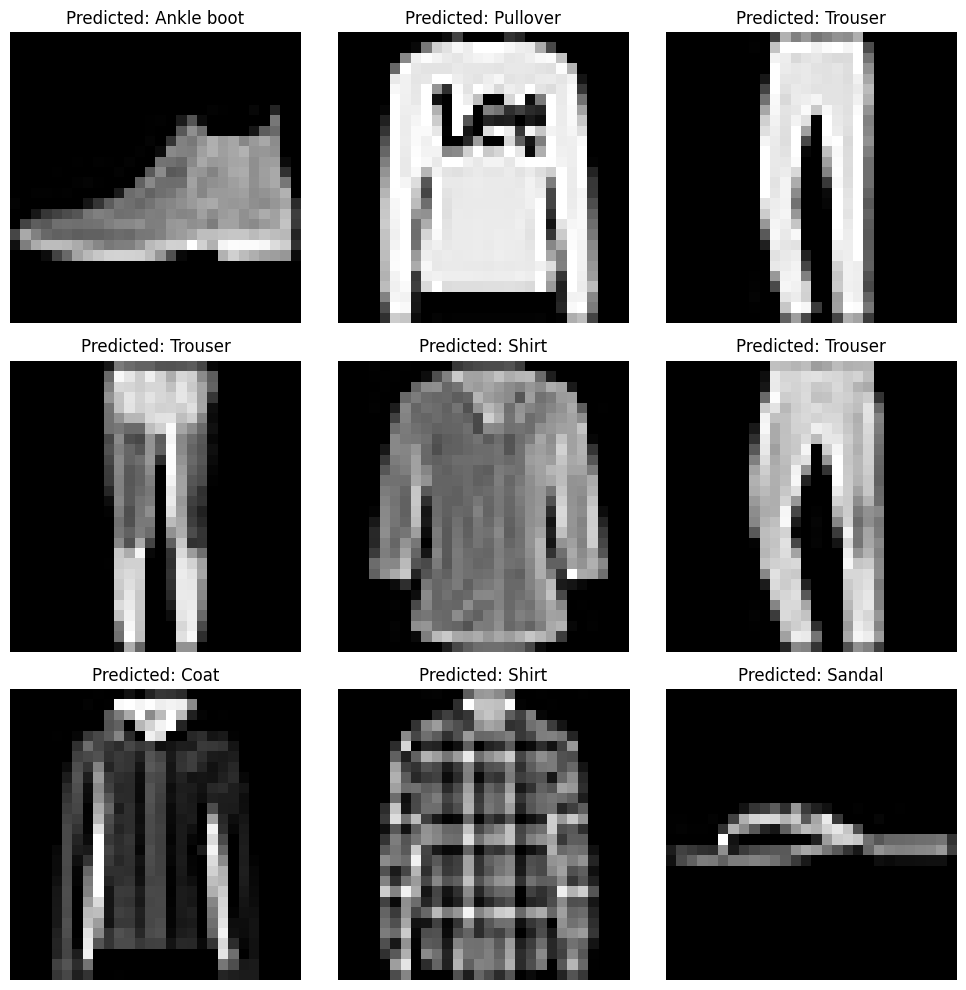

In [ ]:
# Load Fashion MNIST dataset.
(x_train_f, y_train_f), (x_test_f, y_test_f) = tf.keras.datasets.fashion_mnist.load_data()
# Normalize and add channel dimension.
x_train_f = x_train_f.astype('float32') / 255.0
x_test_f = x_test_f.astype('float32') / 255.0
x_train_f = np.expand_dims(x_train_f, -1)
x_test_f = np.expand_dims(x_test_f, -1)
# Use a subset.
x_train_f, y_train_f = x_train_f[:10000], y_train_f[:10000]
x_test_f, y_test_f = x_test_f[:2000], y_test_f[:2000]

# Define a simple CNN.
model_cnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_cnn.build((None, 28, 28, 1))
print("\n-- INTERMEDIATE LEVEL Model Summary (CNN) --")
model_cnn.summary()

# Train and evaluate.
history_cnn = model_cnn.fit(x_train_f, y_train_f, epochs=5, batch_size=32, validation_data=(x_test_f, y_test_f))
test_loss_f, test_acc_f = model_cnn.evaluate(x_test_f, y_test_f)
print(f"\nINTERMEDIATE LEVEL (Fashion MNIST) - Test Accuracy: {test_acc_f:.4f}")

# Visualize a few predictions.
preds_cnn = model_cnn.predict(x_test_f)
predicted_labels = np.argmax(preds_cnn, axis=1)
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_test_f[i].reshape(28,28), cmap='gray')
    plt.title(f"Predicted: {class_names[predicted_labels[i]]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# For multi-label, we convert labels to one-hot encoding.
def preprocess_mnist_multilabel(image, label, target_size=(224, 224)):
    image, label = preprocess_mnist(image, label, target_size)
    label = tf.one_hot(label, depth=10)
    return image, label

train_ds_multi = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds_multi = train_ds_multi.map(preprocess_mnist_multilabel, num_parallel_calls=tf.data.AUTOTUNE)
train_ds_multi = train_ds_multi.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds_multi = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds_multi = test_ds_multi.map(preprocess_mnist_multilabel, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_multi = test_ds_multi.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Define the multi-label classification model.
model_multi = tf.keras.Sequential([
    CustomHubLayer(mobilenet_url, trainable=True, name="feature_extractor_multi"),
    tf.keras.layers.Dense(10, activation='sigmoid', name="multi_classifier")
])
model_multi.build((None, 224, 224, 3))
model_multi.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
print("\n-- ADVANCED LEVEL Model Summary (Multi-Label) --")
model_multi.summary()

# Train and evaluate.
history_multi = model_multi.fit(train_ds_multi, epochs=5, validation_data=test_ds_multi)
test_loss_multi, test_acc_multi = model_multi.evaluate(test_ds_multi)
print(f"\nADVANCED LEVEL - Multi-label Test Accuracy: {test_acc_multi:.4f}")
# Predict sample outputs.
preds_multi = model_multi.predict(test_ds_multi)
print("\nADVANCED LEVEL - Sample Multi-Label Predictions:")
print("Prediction shape:", preds_multi.shape, "DType:", preds_multi.dtype)
print("First sample prediction (each value indicates probability for each class):")
print(preds_multi[0])


-- ADVANCED LEVEL Model Summary (Multi-Label) --


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ feature_extractor_multi              │ (None, 1001)                │               0 │
│ (CustomHubLayer)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ multi_classifier (Dense)             │ (None, 10)                  │          10,020 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,020 (39.14 KB)

 Trainable params: 10,020 (39.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 24s 92ms/step - accuracy: 0.1139 - loss: 0.8716 - val_accuracy: 0.0700 - val_loss: 0.7814
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.3394 - loss: 0.6003 - val_accuracy: 0.2340 - val_loss: 0.5797
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.5020 - loss: 0.4553 - val_accuracy: 0.4860 - val_loss: 0.4222
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.6224 - loss: 0.3711 - val_accuracy: 0.6880 - val_loss: 0.3361
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.7004 - loss: 0.3187 - val_accuracy: 0.7500 - val_loss: 0.2775
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7747 - loss: 0.2658

ADVANCED LEVEL - Multi-label Test Accuracy: 0.7500
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step

ADVANCED LEVEL - Sample Multi-Label Predictions:
Prediction shape: (1000, 10) DType: float32
First sample prediction (each value indicates probability for each class):
[0.15165605 0.6454761  

Image downloaded to: /root/.keras/datasets/test_image.jpg

EXPERT LEVEL - Detection Results Summary:
Output Key                     Shape                     DType     
----------------------------------------------------------------------
raw_detection_boxes            (1, 1917, 4)              float32   
detection_multiclass_scores    (1, 100, 91)              float32   
detection_classes              (1, 100)                  float32   
detection_boxes                (1, 100, 4)               float32   
raw_detection_scores           (1, 1917, 91)             float32   
num_detections                 (1,)                      float32   
detection_anchor_indices       (1, 100)                  float32   
detection_scores               (1, 100)                  float32   


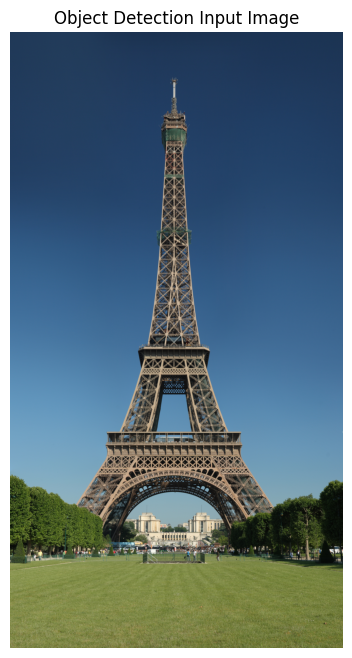

In [ ]:
import cv2
# Download an external image (Eiffel Tower).
image_url_obj = "https://upload.wikimedia.org/wikipedia/commons/a/a8/Tour_Eiffel_Wikimedia_Commons.jpg"
img_path_obj = tf.keras.utils.get_file(fname="test_image.jpg", origin=image_url_obj)
print("Image downloaded to:", img_path_obj)
if not os.path.exists(img_path_obj):
    raise ValueError("Image file was not downloaded. Check your internet connection or URL.")

# Load and preprocess the image using OpenCV.
img = cv2.imread(img_path_obj)
if img is None:
    raise ValueError("cv2.imread failed to load the image. The file may be corrupted or the path is incorrect.")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = tf.cast(tf.image.resize(img_rgb, (300, 300)), tf.uint8)
img_input = tf.expand_dims(img_resized, 0)  # Add batch dimension

# Load SSD MobileNet V2 for object detection from TF Hub.
detector = hub.load("https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2")
raw_result = detector(img_input)
detection_results = {key: value.numpy() for key, value in raw_result.items()}

# Print a summary of detection outputs.
print("\nEXPERT LEVEL - Detection Results Summary:")
print("{:<30} {:<25} {:<10}".format("Output Key", "Shape", "DType"))
print("-" * 70)
for key, value in detection_results.items():
    print("{:<30} {:<25} {:<10}".format(key, str(value.shape), str(value.dtype)))

# Display the input image.
plt.figure(figsize=(8, 8))
plt.imshow(img_rgb)
plt.title("Object Detection Input Image")
plt.axis("off")
plt.show()